In [1]:
train = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\data_distribution\data_distribution8-30/train"
val = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\data_distribution\data_distribution8-30/val"

In [2]:
batch_size = 32
img_height = 150
img_width = 150

In [3]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
  train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode = 'grayscale',
  batch_size=batch_size)

Found 205 files belonging to 10 classes.
Using 164 files for training.


In [4]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


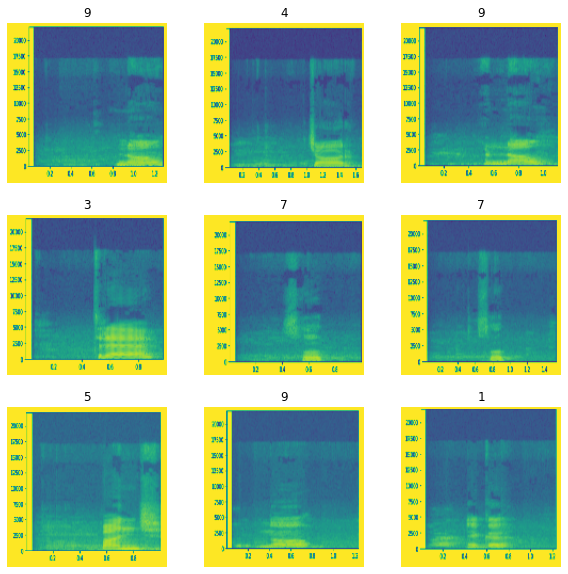

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

In [8]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-08, decay=0.0)
import keras.backend as K
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy',
                   specificity,conditional_average_metric ,sensitivity,F1_Score]

C:\Users\haider computer s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=metrics)

In [10]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
traingen = train_datagen.flow_from_directory(train,
                                              target_size = (150,150),
                                              class_mode  ='categorical',
                                              #classes = class_subset,
                                              subset = 'training',
                                              batch_size = 64,
                                              #color_mode = 'grayscale',
                                              shuffle = True,
                                              seed = 42,
                                              )
valigen = train_datagen.flow_from_directory(val,
                                              target_size = (150,150),
                                              class_mode='categorical',
                                               #classes=class_subset,
                                               #ubset='validation',
                                               #color_mode = 'grayscale',
                                               batch_size=64,
                                               shuffle=True,
                                               seed=42
                                              )


Found 205 images belonging to 10 classes.
Found 94 images belonging to 10 classes.


In [11]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best_CNN.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

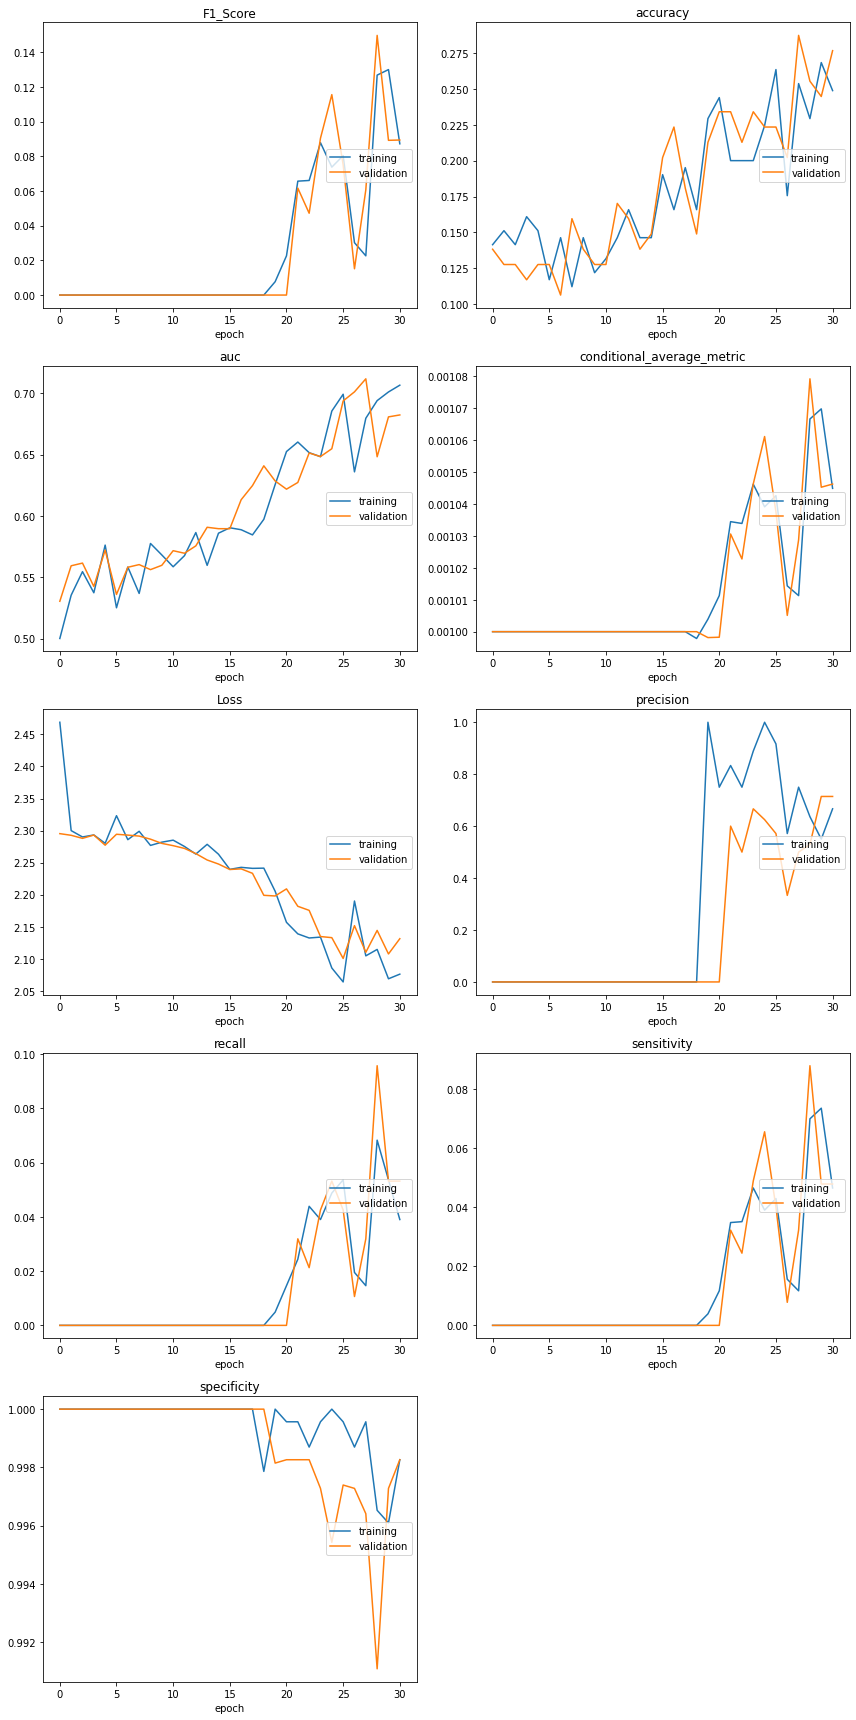

F1_Score
	training         	 (min:    0.000, max:    0.130, cur:    0.087)
	validation       	 (min:    0.000, max:    0.150, cur:    0.089)
accuracy
	training         	 (min:    0.112, max:    0.268, cur:    0.249)
	validation       	 (min:    0.106, max:    0.287, cur:    0.277)
auc
	training         	 (min:    0.500, max:    0.707, cur:    0.707)
	validation       	 (min:    0.530, max:    0.712, cur:    0.682)
conditional_average_metric
	training         	 (min:    0.001, max:    0.001, cur:    0.001)
	validation       	 (min:    0.001, max:    0.001, cur:    0.001)
Loss
	training         	 (min:    2.064, max:    2.469, cur:    2.076)
	validation       	 (min:    2.101, max:    2.295, cur:    2.131)
precision
	training         	 (min:    0.000, max:    1.000, cur:    0.667)
	validation       	 (min:    0.000, max:    0.714, cur:    0.714)
recall
	training         	 (min:    0.000, max:    0.068, cur:    0.039)
	validation       	 (min:    0.000, max:    0.096, cur:    0.053)
sensi

In [ ]:
model.fit_generator(
        traingen,
        epochs=100,
        validation_data=valigen,
        callbacks = [plot_loss_1])


In [ ]:
#model.load_weights('tl_model_v1.weights.best_CNN.hdf5') # initialize the best trained weights
